# Model Selection with WBIC

In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import orbit
print(orbit.__version__)
from orbit.models import DLT, ETS, KTRLite, KTR, LGT
from orbit.utils.simulation import make_trend, make_regression

1.1.0dev


In [2]:
%load_ext autoreload
%autoreload 2

Generate a regression problem with trend with `8` number of regressors where only `3` of them are effective. First, generate the `3` effective regressors.

In [3]:
NUM_OF_REGRESSORS = 8
NUM_OF_EFFECTIVE_REGRESSORS = 3
SERIES_LEN = 100
SEED = 123
# sample some coefficients
COEFS = np.random.default_rng(SEED).uniform(-1, 1, NUM_OF_EFFECTIVE_REGRESSORS)
trend = make_trend(SERIES_LEN, rw_loc=0.01, rw_scale=0.1)
x, regression, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
print(regression.shape, x.shape)

# combine trend and the regression
y = trend + regression
y = y - y.min()

print(COEFS)

(100,) (100, 3)
[ 0.36470373 -0.89235796 -0.55928025]


In [4]:
# add missing data 
missing_idx = np.array([10, 20, 30, 40, 41, 42, 43, 44, 100 - 1])
y[missing_idx] = np.nan


We can add `5` irrelevant regressors into the dataset to add challenge in selecting the best model.

In [5]:
x_extra = np.random.normal(0, 1, (SERIES_LEN, NUM_OF_REGRESSORS - NUM_OF_EFFECTIVE_REGRESSORS))
x = np.concatenate([x, x_extra], axis=-1)
print(x.shape)

(100, 8)


In [6]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y.reshape(-1, 1), x], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
print(df.shape)
print(df.head())

(100, 10)
          y        x1        x2        x3        x4        x5        x6  \
0  3.221238  0.172792  0.000000  0.165219 -1.249982  0.220238  0.394186   
1  3.290044 -0.000000  0.452678  0.223187 -0.370027  0.577354  0.387158   
2  3.009450 -0.000000  0.290559  0.182286 -0.913229 -0.613670 -1.221476   
3  1.504843  0.147066  0.014211  0.273356 -1.641729  2.372297  1.304026   
4  3.999033 -0.368227 -0.081455 -0.241060 -0.020899 -0.169839 -1.446373   

         x7        x8       date  
0  1.955462 -1.353903 2016-01-10  
1 -1.389893 -0.797867 2016-01-17  
2  1.077190 -0.436931 2016-01-24  
3  1.410996 -1.014307 2016-01-31  
4 -0.388509 -2.319550 2016-02-07  


In [7]:
x_cols

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

## DLT

In [8]:
wbic_val_list = []
for p in range(1, 9):
    regressor_col = x_cols[:p]
    print(regressor_col)
    dlt_mod = DLT(
            response_col=response_col,
            date_col=dt_col,
            regressor_col=regressor_col,
            seed=2020,
            # fixing the smoothing parameters to learn regression coefficients more effectively
            level_sm_input=0.01,
            slope_sm_input=0.01,
            num_warmup=4000,
            num_sample=4000,

        )
    wbic_val = dlt_mod.fit_wbic(df=df) #, , sampling_temperature = np.log(100.0)
    wbic_val_list.append(wbic_val)

['x1']


['x1', 'x2']


['x1', 'x2', 'x3']


['x1', 'x2', 'x3', 'x4']


['x1', 'x2', 'x3', 'x4', 'x5']


['x1', 'x2', 'x3', 'x4', 'x5', 'x6']


['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']


['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']


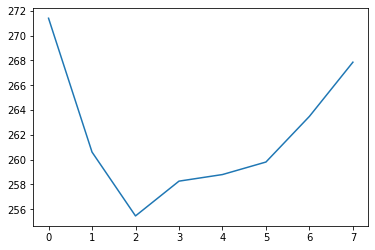

In [9]:
plt.plot(wbic_val_list)

In [10]:
wbic_val_list

[271.4062068539263,
 260.6106482392274,
 255.45957927978858,
 258.2645729189687,
 258.7966882344825,
 259.8072042101491,
 263.49069853103964,
 267.86200704543]

## ETS/LGT/KTR

In [11]:
ets_mod = ETS(
        response_col=response_col,
        date_col=dt_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        level_sm_input=0.01,
        num_warmup=4000,
        num_sample=4000,

    )

ets_mod.fit_wbic(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_16851b025139395720e90c0218ba9f1d NOW.


-129.120959492217

In [17]:
# KTRLite_mod = KTRLite(
#         response_col=response_col,
#         date_col=dt_col,
#         seed=2020,
#         # fixing the smoothing parameters to learn regression coefficients more effectively
#         #level_sm_input=0.01,
#         estimator='stan-map',
#         #num_warmup=4000,
#         #num_sample=4000,

#     )

# KTRLite_mod.fit_wbic(df)

In [13]:
LGT_mod = LGT(
        response_col=response_col,
        date_col=dt_col,
        seed=2020,
        # fixing the smoothing parameters to learn regression coefficients more effectively
        #level_sm_input=0.01,
        estimator='stan-mcmc',
        num_warmup=4000,
        num_sample=4000,

    )

LGT_mod.fit_wbic(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d372bb7bc77e1df83218127fc9dd707d NOW.


-131.0152082056959